In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# 智谱免费GLM-4V-Flash助力多模态RAG实现



**Flash 系列免费模型全家桶上线**——**智谱 BigModel **开放平台重磅推出 Flash 系列免费模型，覆盖语言、图像理解、图像生成、视频生成等多维度能力，均可通过 API 免费调用！无论是多模态应用场景还是复杂业务需求，Flash 系列都能帮助您轻松实现理想效果。本次我们将结合最新的 4V Flash 模型，深入探讨其在多能力、多场景下的创新应用，带您体验 AI 技术的无限可能！

## 1. 引言
多模态检索增强生成(RAG)技术正快速发展，但部署成本较高。智谱科技开放的GLM-4V-Flash作为免费多模态大模型，具备图文理解、知识检索等能力，为构建RAG系统提供了经济实惠的选择。






## 2. GLM-4V-Flash简介

GLM-4V-Flash 是 智谱开放平台（bigmodel.cn）新上线的视觉理解模型，可以理解图片中的语义并做出对应合理的文字输出。

基础能力：图像描述生成、图像分类、视觉推理、视觉问答、图像情感分析等。

模型优势：免费、好用的多模态理解（图片），默认 200 高并发（企业级并发）

核心重点：

- 开放平台之后继 GLM-4-Flash 之后第二个免费开放接口的大模型，也是第一个免费开放的多模态模型。
- 免费的主要原因是智谱开放平台底层的推理技术进一步提升，同时智谱也在继续践行普惠。
- 多模态模型免费后，应用场景将提升一个维度，大模型对社会的影响将会大幅提升。


智谱开放平台BigModel鼓励开发者利用GLM-4V-Flash在图像精准处理方面的优势，将模型的基础能力转化为实际应用场景。无论是信息提取、内容创作还是图片识别等领域，GLM-4V-Flash都能显著提高工作效率和用户体验。

GLM-4V-Flash模型已经在多个行业场景中展现出深远的效益，包括社交媒体文案生成、教育创新支持、美容咨询助手、安全检测、OCR保险单信息提取、工单质量检测、电商商品描述生成和多模态数据标注等。

体验中心:

https://www.bigmodel.cn/console/trialcenter



## 3.多模态向量抽索引构建

向量索引是RAG系统的核心组件，主要包括:
    
- 图像编码：调用CLIP模型获取图像向量
- 向量存储：采用Faiss建立高效索引
- 相似度检索：基于向量距离进行召回



在做RAG之前，信息的信息和组织比较重要，不像文本数据集到处都存在，作为多模态RAG新手，我查阅了一些数据集，发现中文现成的多模态数据集特别少。

下面为一些多模态中文数据集

(1) 华为悟空
悟空，华为，https://wukong-dataset.github.io/wukong-dataset/
The dataset contains 100 Million <image, text> pairs

(2) FLICKR的中文版
flickr30k-cn、flickr8k-cn
https://github.com/weiyuk/fluent-cap

(3)COCO中文版
https://github.com/li-xirong/coco-cn

(4) muge
https://github.com/MUGE-2021，电商数据集ECommerce-IC
MUGE（牧歌，Multimodal Understanding and Generation Evaluation）是业界首个大规模中文多模态评测基准，由达摩院联合浙江大学、阿里云天池平台联合发布，中国计算机学会计算机视觉专委会（CCF-CV专委）协助推出。目前包括：多模态理解与生成任务在内的多模态评测基准，其中包括图像描述、图文检索以及基于文本的图像生成。
模型：M6、OFA

M6-Corpus，J. Lin, R. Men, A. Yang, C. Zhou, M. Ding, Y. Zhang, P. Wang, A. Wang, L. Jiang, X. Jia, et al. M6: A chinese multimodal pretrainer. arXiv preprint arXiv:2103.00823, 2021.
(5) WuDaoCorpora
CogView、悟道2.0、文澜2.0

WuDaoMM：用于预训练模型的大规模多模态数据集
https://github.com/BAAI-WuDao/WuDaoMM/

(6) Product1M
100万图文对儿
X. Zhan, Y. Wu, X. Dong, Y. Wei, M. Lu, Y. Zhang, H. Xu, and X. Liang. Product1m: Towards weakly supervised instance-level product retrieval via cross-modal pretraining. In International Conference on Computer Vision, 2021.

我们使用一个数据集来完成RAG，使用的数据集为：COCO-CN。COCO-CN 是一个双语图像描述数据集，通过手动编写的中文句子和标签丰富了 MS-COCO。新数据集可用于多种任务，包括图像标记、字幕和检索，所有这些都在跨语言环境中完成。
用于数据集比较大，为了方便演示，我们直接使用COCO-CN的测试集。

### 加载数据集

In [2]:
import json
import io
import base64
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import matplotlib.font_manager as fm

# 设置中文字体
# 使用系统自带的中文字体，例如 SimHei（黑体）
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为 SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问
font_path = 'data/simkai.ttf'
font_prop = fm.FontProperties(fname=font_path)

In [3]:
examples=[]
with open("data/test.jsonl","r",encoding="utf-8") as f:
    for line in f.readlines():
        # print(line)
        examples.append(json.loads(line.strip()))
examples[0].keys()

dict_keys(['image_id', 'image_base64', 'caption'])

In [4]:
len(examples)

1000

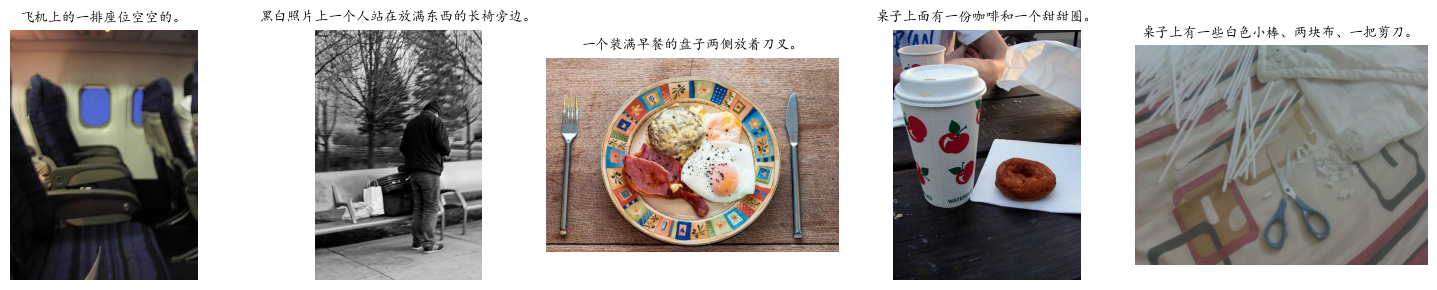

In [5]:
# 可视化多张图片和标题
def visualize_images_and_captions(examples, num_images=5):
    # 创建一个画布和子图
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # 1行，num_images列
    if num_images == 1:
        axes = [axes]  # 如果只有一张图片，确保axes是列表形式
    
    for i, ax in enumerate(axes):
        if i >= len(examples):
            break  # 如果数据不足，提前退出
        example = examples[i]
        
        # 解码Base64图片数据
        image_data = base64.b64decode(example['image_base64'])
        # 将二进制数据转换为图片
        image = Image.open(BytesIO(image_data))
        
        # 显示图片
        ax.imshow(image)
        ax.axis('off')  # 不显示坐标轴
        ax.set_title(example['caption'], fontproperties=font_prop, fontsize=10)  # 设置标题
    
    plt.tight_layout()  # 自动调整子图间距
    plt.show()

# 可视化前五张图片
visualize_images_and_captions(examples, num_images=5)


### 加载CLIP模型

Chinese-CLIP 本项目为CLIP模型的中文版本，使用大规模中文数据进行训练（~2亿图文对），旨在帮助用户快速实现中文领域的图文特征&相似度计算、跨模态检索、零样本图片分类等任务。本项目代码基于open_clip project建设，并针对中文领域数据以及在中文数据上实现更好的效果做了优化。本项目提供了API、训练代码和测试代码，下文中将详细介绍细节。

Chinese-CLIP目前开源5个不同规模，其模型信息和下载方式见下表：

| 模型规模       | 下载链接 | 参数量 | 视觉侧骨架      | 视觉侧参数量 | 文本侧骨架             | 文本侧参数量 | 分辨率 |
|----------------|----------|--------|-----------------|--------------|-----------------------|--------------|--------|
| CN-CLIP RN50   | Download | 77M    | ResNet50        | 38M          | RBT                  | 339M         | 224    |
| CN-CLIP ViT-B/16 | Download | 188M   | ViT-B/16        | 86M          | RoBERTa-wwm-Base      | 102M         | 224    |
| CN-CLIP ViT-L/14 | Download | 406M   | ViT-L/14        | 304M         | RoBERTa-wwm-Base      | 102M         | 224    |
| CN-CLIP ViT-L/14@336px | Download | 407M   | ViT-L/14        | 304M         | RoBERTa-wwm-Base      | 102M         | 336    |
| CN-CLIP ViT-H/14 | Download | 958M   | ViT-H/14        | 632M         | RoBERTa-wwm-Large     | 326M         | 224    |


项目地址为：https://github.com/OFA-Sys/Chinese-CLIP

hf权重地址：https://huggingface.co/OFA-Sys/chinese-clip-vit-base-patch16

modelscope地址：https://modelscope.cn/models/AI-ModelScope/chinese-clip-vit-base-patch16

In [6]:
import torch 
from PIL import Image

import cn_clip.clip as clip
from cn_clip.clip import load_from_name, available_models
print("Available models:", available_models())  
# Available models: ['ViT-B-16', 'ViT-L-14', 'ViT-L-14-336', 'ViT-H-14', 'RN50']

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load_from_name("ViT-B-16", device=device, download_root='data/chinese-clip-vit-base-patch16/')
model.eval()



# image = preprocess(Image.open("data/pokemon.jpeg")).unsqueeze(0).to(device)

# Base64 图片数据
image_base64 = examples[0]["image_base64"]
# 将 Base64 解码为图片
image_data = base64.b64decode(image_base64)
image = Image.open(BytesIO(image_data))
# 预处理图片
image = preprocess(image).unsqueeze(0).to(device)

text = clip.tokenize(["空座位", "妙蛙种子", "小火龙", "皮卡丘"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    # 对特征进行归一化，请使用归一化后的图文特征用于下游任务
    image_features /= image_features.norm(dim=-1, keepdim=True) 
    text_features /= text_features.norm(dim=-1, keepdim=True)    

    logits_per_image, logits_per_text = model.get_similarity(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # [[1.268734e-03 5.436878e-02 6.795761e-04 9.436829e-01]]

Available models: ['ViT-B-16', 'ViT-L-14', 'ViT-L-14-336', 'ViT-H-14', 'RN50']


/home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/utils.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(opened_file, map_

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}
Label probs: [[9.9902e-01 1.2720e-04 1.0884e-04 6.2609e-04]]


In [7]:
image_features.shape

torch.Size([1, 512])

可以看到与第一张图片最相似的查询是“空座位”，复合我们预期

### 多模态检索器实现

接下来我们使用Faiss构建多模态检索器MultimodalRetriever，用于之后的查询检索以及多模态问答

更多检索器可以参考TrustRAG项目：https://github.com/gomate-community/TrustRAG

In [8]:

import torch
import numpy as np
import faiss
import os
import gc
from PIL import Image
import base64
from io import BytesIO
import cn_clip.clip as clip
from typing import List, Tuple, Union, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt

class MultimodalRetrieverConfig():
    """
    Configuration class for Multimodal Retriever.

    Attributes:
        model_name (str): Name of the CLIP model variant (e.g., 'ViT-B-16').
        dim (int): Dimension of the CLIP embeddings (768 for ViT-B-16).
        index_path (str): Path to save or load the FAISS index.
        download_root (str): Directory for downloading CLIP models.
        batch_size (int): Batch size for processing multiple documents.
    """

    def __init__(
            self,
            model_name='ViT-B-16',
            dim=768,
            index_path='./index',
            download_root='./',
            batch_size=32
    ):
        self.model_name = model_name
        self.dim = dim
        self.index_path = index_path
        self.download_root = download_root
        self.batch_size = batch_size

    def validate(self):
        """Validate Multimodal configuration parameters."""
        if not isinstance(self.model_name, str) or not self.model_name:
            raise ValueError("Model name must be a non-empty string.")
        if not isinstance(self.dim, int) or self.dim <= 0:
            raise ValueError("Dimension must be a positive integer.")
        if not isinstance(self.index_path, str):
            raise ValueError("Index path must be a string.")
        if not isinstance(self.download_root, str):
            raise ValueError("Download root must be a string.")
        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("Batch size must be a positive integer.")
        print("Multimodal configuration is valid.")


class MultimodalRetriever():
    def __init__(self, config):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load_from_name(
            config.model_name,
            device=self.device,
            download_root=config.download_root
        )
        self.model.eval()
        self.dim = config.dim # CLIP embedding dimension
        self.index = faiss.IndexFlatIP(self.dim)
        self.embeddings = []
        self.documents = []  # List to store (image_path, text) pairs
        self.num_documents = 0
        self.index_path = config.index_path
        self.batch_size = config.batch_size

    def convert_base642image(self, image_base64):
        image_data = base64.b64decode(image_base64)
        image = Image.open(BytesIO(image_data))
        return image

    def merge_mm_embeddings(self, img_emb=None, text_emb=None):
        if text_emb is not None and img_emb is not None:
            return np.mean([img_emb, text_emb], axis=0)
        elif text_emb is not None:
            return text_emb
        elif img_emb is not None:
            return img_emb
        raise ValueError("Must specify one of `img_emb` or `text_emb`")

    def _embed(self, image=None, text=None) -> np.ndarray:
        if image is None and text is None:
            raise ValueError("Must specify one of image or text")

        img_emb = None
        text_emb = None

        if image is not None:
            image = self.preprocess(image).unsqueeze(0).to(self.device)
            with torch.no_grad():
                img_emb = self.model.encode_image(image)
                img_emb /= img_emb.norm(dim=-1, keepdim=True)
                img_emb = img_emb.cpu().numpy()

        if text is not None:
            text = clip.tokenize([text]).to(self.device)
            with torch.no_grad():
                text_emb = self.model.encode_text(text)
                text_emb /= text_emb.norm(dim=-1, keepdim=True)
                text_emb = text_emb.cpu().numpy()

        return self.merge_mm_embeddings(img_emb, text_emb)

    def add_image_text(self, image: Union[str, Image.Image], text: str):
        """Add a single image-text pair to the index."""
        if isinstance(image, str):
            image = self.convert_base642image(image_base64=image)

        emb = self._embed(image=image, text=text).astype('float32')
        self.index.add(emb)
        self.embeddings.append(emb)
        self.documents.append((image, text))
        self.num_documents += 1

    def build_from_pairs(self, img_text_pairs: List[Tuple[Union[str, Image.Image], str]]):
        """Build index from image-text pairs in batches."""
        if not img_text_pairs:
            raise ValueError("Image-text pairs list is empty")

        for i in tqdm(range(0, len(img_text_pairs), self.batch_size), desc="Building index"):
            batch = img_text_pairs[i:i + self.batch_size]
            for img, text in batch:
                self.add_image_text(img, text)

    def save_index(self, index_path: str = None):
        """Save the index, embeddings, and document pairs."""
        if not (self.index and self.embeddings and self.documents):
            raise ValueError("No data to save")

        if index_path is None:
            index_path = self.index_path

        os.makedirs(index_path, exist_ok=True)

        # Save embeddings and document information
        np.savez(
            os.path.join(index_path, 'multimodal.vecstore'),
            embeddings=np.array(self.embeddings),
            documents=np.array(self.documents, dtype=object)
        )

        # Save FAISS index
        faiss.write_index(self.index, os.path.join(index_path, 'multimodal.index'))
        print(f"Index saved successfully to {index_path}")

    def load_index(self, index_path: str = None):
        """Load the index, embeddings, and document pairs."""
        if index_path is None:
            index_path = self.index_path

        # Load document data
        data = np.load(os.path.join(index_path, 'multimodal.vecstore.npz'),
                       allow_pickle=True)
        self.documents = data['documents'].tolist()
        self.embeddings = data['embeddings'].tolist()

        # Load FAISS index
        self.index = faiss.read_index(os.path.join(index_path, 'multimodal.index'))
        self.num_documents = len(self.documents)

        print(f"Index loaded successfully from {index_path}")
        del data
        gc.collect()

    def retrieve(self, query: Union[str, Image.Image], top_k: int = 5) -> List[Dict]:
        """Retrieve top_k most relevant image-text pairs."""
        if self.index is None or self.num_documents == 0:
            raise ValueError("Index is empty or not initialized")

        # Generate query embedding
        query_embedding = self._embed(
            image=query if isinstance(query, Image.Image) else None,
            text=query if isinstance(query, str) else None
        ).astype('float32')

        # Search index
        D, I = self.index.search(query_embedding, min(top_k, self.num_documents))

        # Return results with scores
        results = []
        for idx, score in zip(I[0], D[0]):
            image, text = self.documents[idx]
            results.append({
                'image': image,
                'text': text,
                'score': float(score)
            })

        return results
    
    def plot_results(self, query: Union[str, Image.Image], results: List[Dict], font_path: str = None):
        """
        Plot query and retrieval results with dynamic sizing and font support.

        Args:
            query: Text string or PIL Image
            results: List of retrieval results
            font_path: Path to font file for Chinese text support
        """
        # plt.close('all')  # Close any existing figures
        n_results = len(results)
        # Dynamic figure size: base width (3) for query + width for each result (3)
        figsize = (3 * (n_results + 1), 4)

        fig = plt.figure(figsize=figsize)

        # Set font for Chinese characters if provided
        if font_path:
            from matplotlib.font_manager import FontProperties
            font = FontProperties(fname=font_path)
        else:
            font = None

        # Plot query
        if isinstance(query, str):
            ax = plt.subplot(1, n_results + 1, 1)
            ax.text(0.5, 0.5, f"Query Text:\n{query}", 
                    ha='center', va='center', wrap=True,
                    fontproperties=font)
            ax.axis('off')
        else:
            plt.subplot(1, n_results + 1, 1)
            plt.imshow(query)
            plt.title("Query Image", fontproperties=font)
            plt.axis('off')

        # Plot results
        for idx, result in enumerate(results, 1):
            plt.subplot(1, n_results + 1, idx + 1)
            plt.imshow(result['image'])
            plt.title(f"Score: {result['score']:.3f}\n{result['text']}", 
                     pad=10, fontproperties=font)
            plt.axis('off')

        plt.tight_layout()
        # return fig


初始化多模态检索器

In [9]:
# 初始化配置
config = MultimodalRetrieverConfig(
    model_name='ViT-B-16',
    index_path='./index',
    batch_size=32,
    dim=512,
    download_root="data/chinese-clip-vit-base-patch16/"
)

# 创建检索器示例
retriever = MultimodalRetriever(config)

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


构建索引

In [10]:
%%time
# 对 examples构建索引
img_text_pairs = [(ex['image_base64'], ex['caption']) for ex in examples]
retriever.build_from_pairs(img_text_pairs)

Building index: 100%|██████████| 32/32 [00:16<00:00,  1.92it/s]

CPU times: user 5min 57s, sys: 838 ms, total: 5min 58s
Wall time: 16.7 s


- 测试检索效果-文本查询

In [11]:
# 我们测试检索结果，使用文本检索
query_text = "飞机"
results = retriever.retrieve(query_text, top_k=3)
results

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x457>,
  'text': '一架飞机',
  'score': 0.707410991191864},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x483>,
  'text': '一架飞机飞在空中',
  'score': 0.6677590608596802},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x426>,
  'text': '一架飞机正飞在天空中',
  'score': 0.6380719542503357}]

In [12]:
for i, result in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"Text: {result['text']}")
    print(f"Score: {result['score']:.4f}")


Result 1:
Text: 一架飞机
Score: 0.7074

Result 2:
Text: 一架飞机飞在空中
Score: 0.6678

Result 3:
Text: 一架飞机正飞在天空中
Score: 0.6381


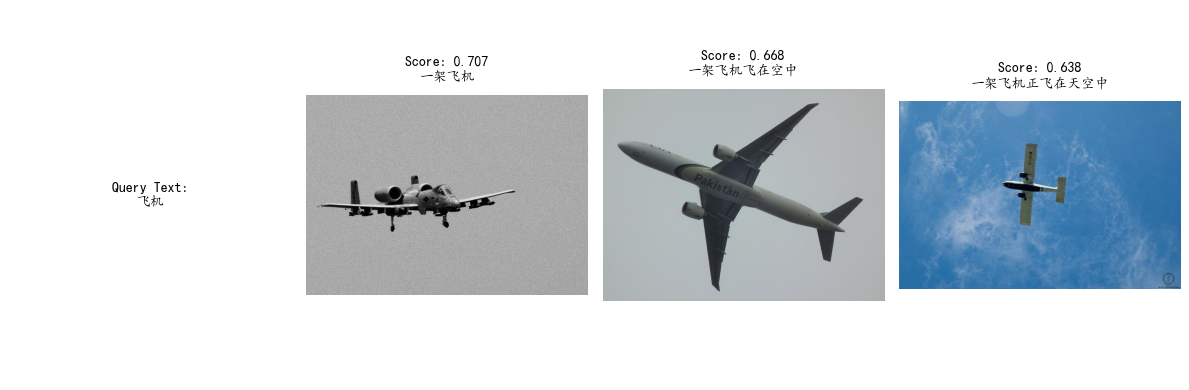

In [13]:
fig=retriever.plot_results(query_text,results,font_path="data/simkai.ttf")

- 测试检索效果-图像查询

我们尝试图片进行检索

In [14]:
# 测试图片检索
query_image = retriever.convert_base642image(examples[2]['image_base64'])
results = retriever.retrieve(query_image, top_k=3)
results

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x425>,
  'text': '一个装满早餐的盘子两侧放着刀叉。',
  'score': 0.7156937122344971},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612>,
  'text': '盘子里有土豆、蔬菜和一些肉类。',
  'score': 0.5763481855392456},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  'text': '桌子上有一杯果汁和一盘食物，里面有松饼、鸡蛋和肉。',
  'score': 0.5653255581855774}]

In [15]:
for i, result in enumerate(results, 1):
    print(f"\nResult {i}:")
    print(f"Text: {result['text']}")
    print(f"Score: {result['score']:.4f}")


Result 1:
Text: 一个装满早餐的盘子两侧放着刀叉。
Score: 0.7157

Result 2:
Text: 盘子里有土豆、蔬菜和一些肉类。
Score: 0.5763

Result 3:
Text: 桌子上有一杯果汁和一盘食物，里面有松饼、鸡蛋和肉。
Score: 0.5653


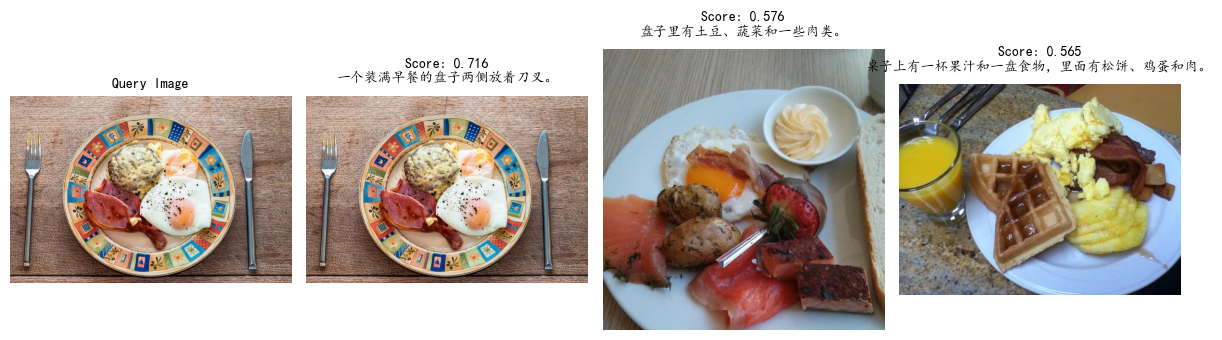

In [16]:
fig=retriever.plot_results(query_image,results,font_path="data/simkai.ttf")

保存索引，以便下次使用

In [17]:
# 保存索引
retriever.save_index()

Index saved successfully to ./index


现在索引保存好了，我们测试下是否保存成功，以及是否可以重新加载

In [18]:
del retriever

In [19]:
# 初始化配置
config = MultimodalRetrieverConfig(
    model_name='ViT-B-16',
    index_path='./index',
    batch_size=32,
    dim=512,
    download_root="data/chinese-clip-vit-base-patch16/"
)

# 创建检索器示例
retriever = MultimodalRetriever(config)

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [20]:
# 加载索引
retriever.load_index()

Index loaded successfully from ./index


In [21]:
# 测试图片检索
query_image = retriever.convert_base642image(examples[10]['image_base64'])
results = retriever.retrieve(query_image, top_k=3)
results

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=612x612>,
  'text': '一个女人拿着冲浪板站在海滩上',
  'score': 0.7353235483169556},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640>,
  'text': '一个女性冲浪者正在海洋上用冲浪板冲浪',
  'score': 0.6604689359664917},
 {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x426>,
  'text': '阳光下，一个人抱着一块冲浪板在海滩上奔跑。',
  'score': 0.6543064117431641}]

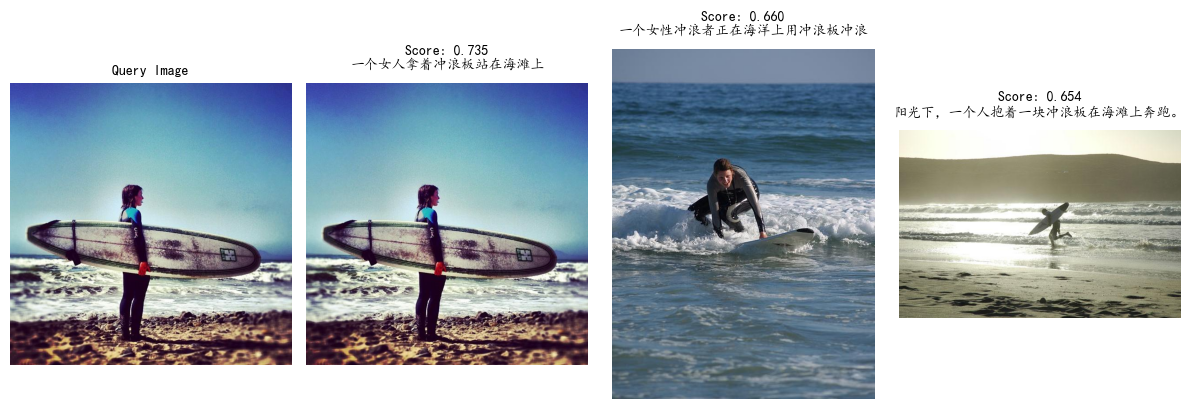

In [22]:
fig=retriever.plot_results(query_image,results,font_path="/home/jovyan/codes/simkai.ttf")

到这，我们多模态检索器大功搞成了

## 4. 多模态聊天实现

GLM-4V-Flash（免费）: 专注于高效的单一图像理解，适用于图像解析的场景，例如实时图像分析或批量图像处理。接下来我们使用`zhipuapi`来请求`GLM-4V-Flash`实现对话聊天

具体接口文档我们可以参考：https://www.bigmodel.cn/dev/api/normal-model/glm-4v

创建自己的api_key:https://www.bigmodel.cn/usercenter/proj-mgmt/apikeys

### 上传图片 Base64

In [23]:
your_key="3afef68ae0bbeaf1a6447c882c1c3c83.Lu5ZqFjI6yzj7yNB" #记得修改成自己的api_key

In [24]:
import base64
from zhipuai import ZhipuAI

img_path = "data/pokemon.jpeg"
with open(img_path, 'rb') as img_file:
    img_base = base64.b64encode(img_file.read()).decode('utf-8')

client = ZhipuAI(api_key=your_key) # 填写您自己的APIKey
response = client.chat.completions.create(
    model="glm-4v-plus",  # 填写需要调用的模型名称
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "image_url",
            "image_url": {
                "url": img_base
            }
          },
          {
            "type": "text",
            "text": "请描述这个图片"
          }
        ]
      }
    ]
)
print(response.choices[0].message)

CompletionMessage(content='这张图片展示了一个坐着的卡通角色，它有一个圆形的黄色身体，大大的黑色眼睛，一个小小的红色鼻子，以及一个宽阔的、友好的笑容。它有长长的耳朵，耳朵内侧是黑色。这个角色看起来很开心，似乎在挥手打招呼。它手里拿着一个黄色的物体，像是 Pikachu的尾巴。  \n这个角色是皮卡丘，是日本任天堂公司发行的掌机游戏系列《宝可梦》中登场的虚构生物，也任天堂3DS掌机及根据游戏改编的动画电影《精灵宝可梦》中的主角“小智”的伙伴。皮卡丘以其黄色的外观、元宝形状的尾巴和耳朵内黑色的部分，以及使用电的特性而闻名，被称为“电气老鼠”。它活泼好动，充满活力，有时会显得有些调皮。皮卡丘在整个《精灵宝可梦》系列中扮演着重要角色，尤其在电影和动画中，它是小智最忠实的伙伴，也是许多粉丝心中最具代表性的宝可梦之一。', role='assistant', tool_calls=None)


我们测试一下

In [25]:
import base64
from zhipuai import ZhipuAI

img_base =examples[0]["image_base64"]

client = ZhipuAI(api_key=your_key) # 填写您自己的APIKey
response = client.chat.completions.create(
    model="glm-4v-plus",  # 填写需要调用的模型名称
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "image_url",
            "image_url": {
                "url": img_base
            }
          },
          {
            "type": "text",
            "text": "请描述这个图片"
          }
        ]
      }
    ]
)
print(response.choices[0].message)

CompletionMessage(content='这张图片显示的是飞机内部的情景。可以看到排列整齐的座椅，座椅颜色为深蓝色和灰色。座椅背后有窗户，窗外是夜晚的黑暗。图片有些模糊，看起来像是用较慢的快门速度拍摄，因此可能表现出轻微的运动模糊效果。', role='assistant', tool_calls=None)


### 上传图片 URL

In [26]:
from zhipuai import ZhipuAI
client = ZhipuAI(api_key=your_key) # 填写您自己的APIKey
response = client.chat.completions.create(
    model="glm-4v",  # 填写需要调用的模型名称
    messages=[
       {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": "图里有什么"
          },
          {
            "type": "image_url",
            "image_url": {
                "url" : "https://img1.baidu.com/it/u=1369931113,3388870256&fm=253&app=138&size=w931&n=0&f=JPEG&fmt=auto?sec=1703696400&t=f3028c7a1dca43a080aeb8239f09cc2f"
            }
          }
        ]
      }
    ]
)
print(response.choices[0].message)

CompletionMessage(content='图中有一片湛蓝的海面、蓝天白云和岩石海岸线，海面上方有零星分布的云朵，海岸线上有一些树木。', role='assistant', tool_calls=None)


## 5. 多模态RAG实现

完整RAG系统架构包含：
- 知识库构建：导入和索引多模态数据
- 查询处理：分析用户输入并生成查询向量
- 知识检索：从索引中召回相关内容
- 答案生成：结合上下文生成回答


### 多模态RAG初体验

In [27]:
import base64
from typing import List, Dict, Any
from zhipuai import ZhipuAI
from PIL import Image

class MultimodalRAG:
    def __init__(
        self,
        api_key: str,
        retriever_config: MultimodalRetrieverConfig,
        model_name: str = "glm-4v-plus",
        top_k: int = 3
    ):
        self.client = ZhipuAI(api_key=api_key)
        self.retriever = MultimodalRetriever(retriever_config)
        # self.retriever.load_index()
        self.model_name = model_name
        self.top_k = top_k

    def _prepare_context(self, results: List[Dict[str, Any]]) -> str:
        context = "基于以下相似图片信息：\n"
        for idx, result in enumerate(results, 1):
            context += f"{idx}. {result['text']} (相似度: {result['score']:.2f})\n"
        return context

    def _image_to_base64(self, image: Image) -> str:
        # Convert the image to RGB mode if it's in RGBA mode
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        # Save the image to a BytesIO buffer in JPEG format
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG")

        # Encode the image data to base64 and return it as a string
        return base64.b64encode(buffered.getvalue()).decode('utf-8')

    def chat(self, query: str, include_images: bool = True) -> str:
        # 1. 检索相似内容
        results = self.retriever.retrieve(query, top_k=self.top_k)
        
        # 2. 准备提示信息
        context = self._prepare_context(results)
        full_prompt = f"{context}\n用户问题: {query}\n请基于用户提供的图片和上述图片信息回答问题。"
        
        # 3. 准备消息内容
        messages = [{"role": "user", "content": []}]
        
        # 4. 如果需要，添加检索到的图片
        if include_images:
            for result in results:
                img_base64 = self._image_to_base64(result['image'])
                messages[0]["content"].append({
                    "type": "image_url",
                    "image_url": {"url": img_base64}
                })
        
        messages[0]["content"].append({"type": "text", "text": full_prompt})
        # 5. 调用API获取回答
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=messages
        )
        
        return results,response.choices[0].message.content

    def chat_with_image(self, query: str, image_path: str) -> str:
        # 1. 读取和编码用户提供的图片
        with open(image_path, 'rb') as img_file:
            user_img_base64 = base64.b64encode(img_file.read()).decode('utf-8')
        
        # 2. 检索相似内容
        results = self.retriever.retrieve(query, top_k=self.top_k)
        
        # 3. 准备提示信息
        context = self._prepare_context(results)
        full_prompt = f"{context}\n用户问题: {query}\n请基于用户提供的图片和上述相似图片信息回答问题。"
        
        # 4. 准备消息内容，首先添加用户的图片
        messages = [{
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": user_img_base64}
                },
                {
                    "type": "text",
                    "text": full_prompt
                }
            ]
        }]
        
        # 5. 添加检索到的相似图片
        for result in results:
            img_base64 = self._image_to_base64(result['image'])
            messages[0]["content"].append({
                "type": "image_url",
                "image_url": {"url": img_base64}
            })
        
        # 6. 调用API获取回答
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=messages
        )
        
        return response.choices[0].message.content

In [28]:
# 初始化
rag = MultimodalRAG(
    api_key=your_key,
    retriever_config=config,
    top_k=1
)

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [29]:
rag.retriever.load_index()

Index loaded successfully from ./index


In [30]:
# 纯文本查询
query_text="描述一下飞机的样子"
retrieve_results,response = rag.chat("描述一下飞机的样子")
retrieve_results,response

([{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x483>,
   'text': '一架飞机飞在空中',
   'score': 0.6501482725143433}],
 '这架飞机是一架大型客机，机身上印有“Pakistan”字样。飞机的机身呈白色，机翼较长，并配有双引擎。机尾部分有垂直尾翼，整体设计流线型，适合长途飞行。')

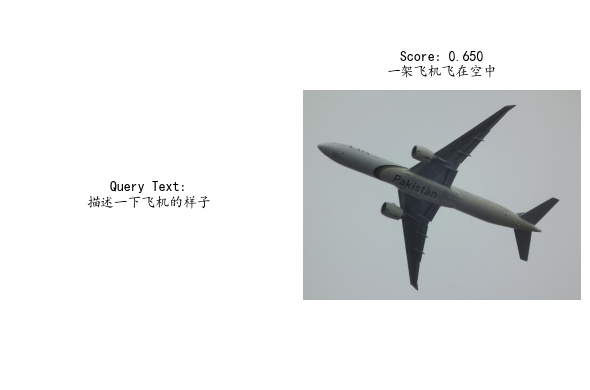

In [31]:
rag.retriever.plot_results(query_text,retrieve_results,font_path="data/simkai.ttf")

上面是一个简单的demo体验，为了更好的体现多模态RAG的效果以及GLM-4V-Flash的能力，我们下面用两个案例来演示多模态RAG问答

### 案例1：医学多模态RAG助手

In [32]:
# 初始化配置
medical_retriever_config = MultimodalRetrieverConfig(
    model_name='ViT-B-16',
    index_path='./index_medical',
    batch_size=32,
    dim=512,
    download_root="data/chinese-clip-vit-base-patch16/"
)

In [33]:
# 初始化
medical_rag = MultimodalRAG(
    api_key=your_key,
    retriever_config=medical_retriever_config
)

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [34]:
!ls data/examples/medical/ | head -n 10

医学知识讲座_01.png
医学知识讲座_02.png
医学知识讲座_03.png
医学知识讲座_04.png
医学知识讲座_05.png
医学知识讲座_06.png
医学知识讲座_07.png
医学知识讲座_08.png
医学知识讲座_09.png
医学知识讲座_10.png


In [35]:
# 定义目录路径
directory = 'data/examples/medical/'
medical_examples=[]
# 遍历目录下的所有文件
for filename in os.listdir(directory):
    if filename.endswith('.png'):  # 只处理 .png 文件
        file_path = os.path.join(directory, filename)
        
        # 读取文件并转换为 Base64
        with open(file_path, 'rb') as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            medical_examples.append({"image_base64":encoded_string,"caption":None})
img_text_pairs = [(ex['image_base64'], ex['caption']) for ex in medical_examples]

In [36]:
medical_rag.retriever.build_from_pairs(img_text_pairs)
medical_rag.retriever.save_index()

Building index: 100%|██████████| 3/3 [00:24<00:00,  8.11s/it]


Index saved successfully to ./index_medical


In [37]:
# 高脂血症患者的食物疗法 医学知识讲座_26.png
query_text="高脂血症患者的食物疗法"
retrieve_results,response=medical_rag.chat(query_text)
retrieve_results,response

([{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=3840x2880>,
   'text': None,
   'score': 0.5025367140769958},
  {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=3840x2880>,
   'text': None,
   'score': 0.499972403049469},
  {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=3840x2880>,
   'text': None,
   'score': 0.4712710380554199}],
 '高脂血症患者的食物疗法主要包括以下几种食物：\n\n1. **大蒜**：具有舒张血管、抗血小板凝集和阻止胆固醇的生物合成作用，并具有杀菌解毒功效。\n\n2. **洋葱**：有降血脂和抗动脉硬化作用，对高血压病人还有降压作用。\n\n3. **黑木耳**：具有抗血小板凝集、降低血脂和阻止胆固醇沉积作用。\n\n4. **香菇**：能促进新陈代谢，降低血压、降低血脂，并能降低肝脏中脂肪和胆固醇的含量。\n\n5. **豆制品**：含有植物固醇和卵磷脂，能阻止肠道吸收食物中的胆固醇，并减少胆固醇沉积在血管壁上形成动脉硬化的斑块。\n\n6. **海鱼**：降脂作用也很好，日本人患高脂血症和冠心病的较少，主要与喜爱食海鱼有关。\n\n7. **黄瓜**：具有清凉、解渴、利尿作用，富含纤维素能促进肠蠕动，减少肠道对胆固醇的吸收。\n\n这些食物不仅有助于降低血脂，还能软化动脉血管，对预防心脑血管疾病有益。同时，患者应避免食用高胆固醇食物，如蛋黄、动物内脏等，并减少摄入高糖、高脂肪食物，以维持健康的饮食习惯。')

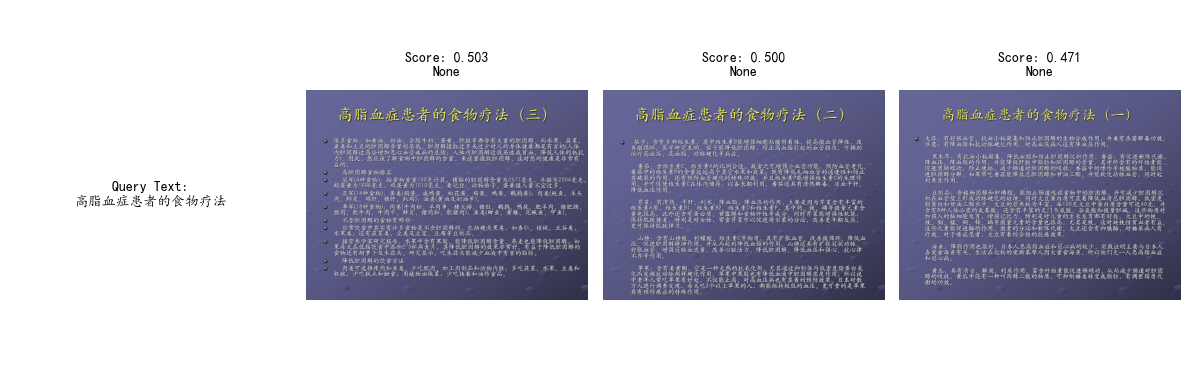

In [38]:
medical_rag.retriever.plot_results(query_text,retrieve_results,font_path="data/simkai.ttf")

我们可以看到关于“高脂血症患者的食物疗法”问题，我们的多模态RAG都检索到了，并且GLM-4V-Flash基于图片内容进行回答

### 案例2：汽车保养多模态RAG助手

In [39]:
# 初始化配置
car_retriever_config = MultimodalRetrieverConfig(
    model_name='ViT-B-16',
    index_path='./index_car',
    batch_size=32,
    dim=512,
    download_root="data/chinese-clip-vit-base-patch16/"
)
# 初始化
car_rag = MultimodalRAG(
    api_key=your_key,
    retriever_config=car_retriever_config,
    top_k=1
)

Loading vision model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from /home/jovyan/codes/envs/gomate/lib/python3.10/site-packages/cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
Model info {'embed_dim': 512, 'image_resolution': 224, 'vision_layers': 12, 'vision_width': 768, 'vision_patch_size': 16, 'vocab_size': 21128, 'text_attention_probs_dropout_prob': 0.1, 'text_hidden_act': 'gelu', 'text_hidden_dropout_prob': 0.1, 'text_hidden_size': 768, 'text_initializer_range': 0.02, 'text_intermediate_size': 3072, 'text_max_position_embeddings': 512, 'text_num_attention_heads': 12, 'text_num_hidden_layers': 12, 'text_type_vocab_size': 2}


In [40]:
# 定义目录路径
directory = 'data/examples/car/'
medical_examples=[]
# 遍历目录下的所有文件
for filename in os.listdir(directory):
    if filename.endswith('.png'):  # 只处理 .png 文件
        file_path = os.path.join(directory, filename)
        
        # 读取文件并转换为 Base64
        with open(file_path, 'rb') as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            medical_examples.append({"image_base64":encoded_string,"caption":None})
img_text_pairs = [(ex['image_base64'], ex['caption']) for ex in medical_examples]

car_rag.retriever.build_from_pairs(img_text_pairs)
car_rag.retriever.save_index()

Building index: 100%|██████████| 4/4 [00:58<00:00, 14.53s/it]


Index saved successfully to ./index_car


In [43]:
query_text="冷却系统检查"
retrieve_results,response=car_rag.chat(query_text)
retrieve_results,response

([{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=5120x2880>,
   'text': None,
   'score': 0.44340047240257263}],
 '根据您提供的图片信息，冷却系统检查的步骤如下：\n\n1. **散热器泄漏测试**：\n   - 等待发动机冷却后，小心拆卸散热器盖并用发动机冷却水注满散热器。\n   - 将测压器安装在散热器加水口上。\n   - 加压至93~123kPa的压力。\n   - 检查发动机冷却水有无泄漏和压力下降情况。\n   - 拆卸测压器并重新安装散热器盖。\n\n2. **注意事项**：\n   - 发动机热机状态下切勿打开水箱盖，否则，发动机冷却液在压力作用下可能喷出，造成烫伤事故。\n\n请确保在执行这些步骤时注意安全，并遵循正确的操作流程。')

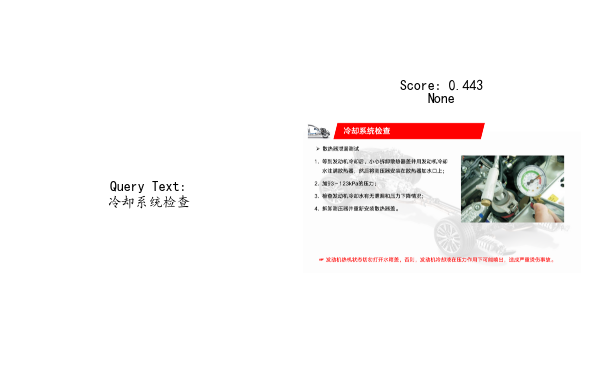

In [44]:
car_rag.retriever.plot_results(query_text,retrieve_results,font_path="data/simkai.ttf")

## 6. 结论
GLM-4V-Flash为构建多模态RAG系统提供了理想选择：
- 免费开放，降低使用门槛
- 性能可靠，响应迅速
- 接口简单，易于集成
- 功能齐全，应用广泛

智谱 BigModel 开放平台的 Flash 系列免费模型全家桶，不仅降低了 AI 技术的使用门槛，更为开发者提供了强大的工具支持。无论是语言处理、图像理解，还是图像生成、视频生成，Flash 系列都能满足您的多样化需求。现在就来体验 4V Flash 模型的强大能力，开启您的 AI 创新之旅吧！免费调用 API，轻松实现多维度应用场景的理想效果！